# Clustering chemicals based on their descriptors

The scripts bellow use K-Means clustering the classify the merged FEMA-JECFA chemicals based on the merged descriptors obtained in [fema_jecfa_merge](fema_jecfa_merge.ipynb)

In [1]:
import os.path as path
import pickle

# Load merged FEMA-JECFA database
BASE_DATA_PATH = path.join(path.expanduser('~'),
                           'Dropbox',
                           'bymt',
                           'data_dumps',
                           'chem_project')

merged_chemicals_path = path.join(BASE_DATA_PATH, 'fema_jecfa_merge', 'merged_chemicals.pkl')
with open(merged_chemicals_path, 'rb') as f:
    merged_chemicals = pickle.load(f)

Add unique id numbers to the chemicals in merged list so that I can relate their classification back to their chemical

In [2]:
from copy import deepcopy

def add_id(dicto_list):
    """
    Add unique id numbers to the dictos in dicto_list.
    Each id is the index of that dicto in the list.
    """
    new_list = deepcopy(dicto_list)
    for i, dicto in enumerate(new_list):
        dicto['id'] = i
    return new_list

In [3]:
id_chemicals = add_id(merged_chemicals)
print(id_chemicals[0]['id'])

0


Create list of tuples pairing chemical id with its merged descriptors as input for K-means clustering

In [14]:
def id_descriptor_lists(dicto_list):
    """
    Creates paired lists. One with ids, the other with merged descriptors
    """
    ids, descriptors = [], []
    for dicto in dicto_list:
        ids.append(dicto['id'])
        descriptors.append(dicto['merged descriptors'])
    return ids, descriptors

In [15]:
ids, descriptors = id_descriptor_lists(id_chemicals)
print('lengths make sense: {}' .format(len(descriptors)==len(id_chemicals)))

lengths make sense: True


In [47]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_df=0.75, 
                             stop_words='english',
                             norm='l2',
                             ngram_range=(1,1))

descriptor_vector = vectorizer.fit_transform(descriptors)
print(descriptor_vector.shape)

(2193, 676)


In [51]:
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

X = descriptor_vector

n_components = 230
if n_components:
    print("Performing dimensionality reduction using LSA")
    # Vectorizer results are normalized, which makes KMeans behave as
    # spherical k-means for better results. Since LSA/SVD results are
    # not normalized, we have to redo the normalization.
    svd = TruncatedSVD(n_components)
    normalizer = Normalizer(copy=False)
    lsa = make_pipeline(svd, normalizer)

    X = lsa.fit_transform(X)

    explained_variance = svd.explained_variance_ratio_.sum()
    print("Explained variance of the SVD step: {}%".format(
        int(explained_variance * 100)))

    print()

Performing dimensionality reduction using LSA
Explained variance of the SVD step: 90%



For n_clusters = 2 The average silhouette_score is : 0.0312632799986


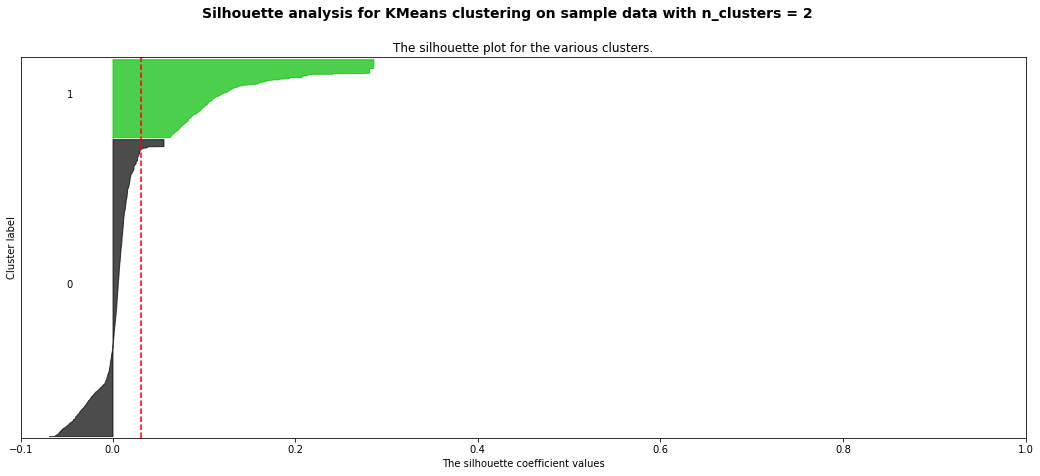

For n_clusters = 3 The average silhouette_score is : 0.0471264554666


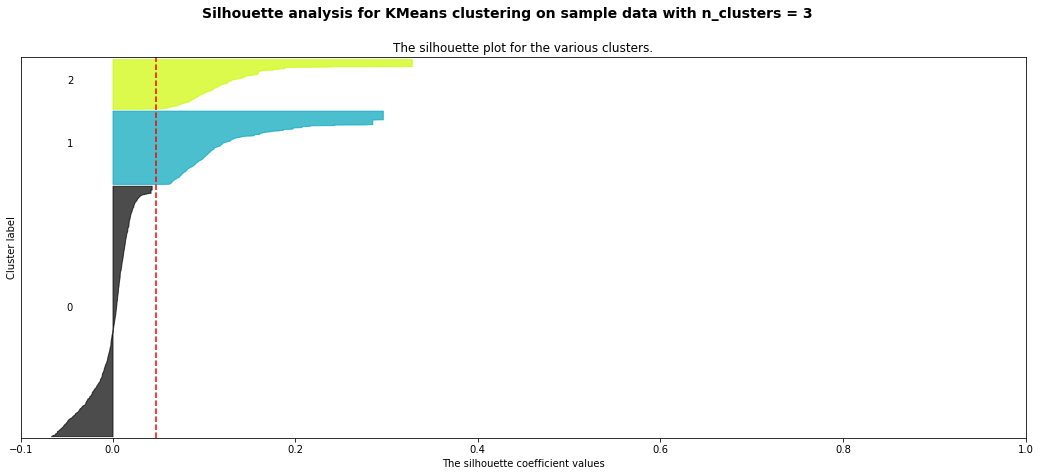

For n_clusters = 4 The average silhouette_score is : 0.0563659626271


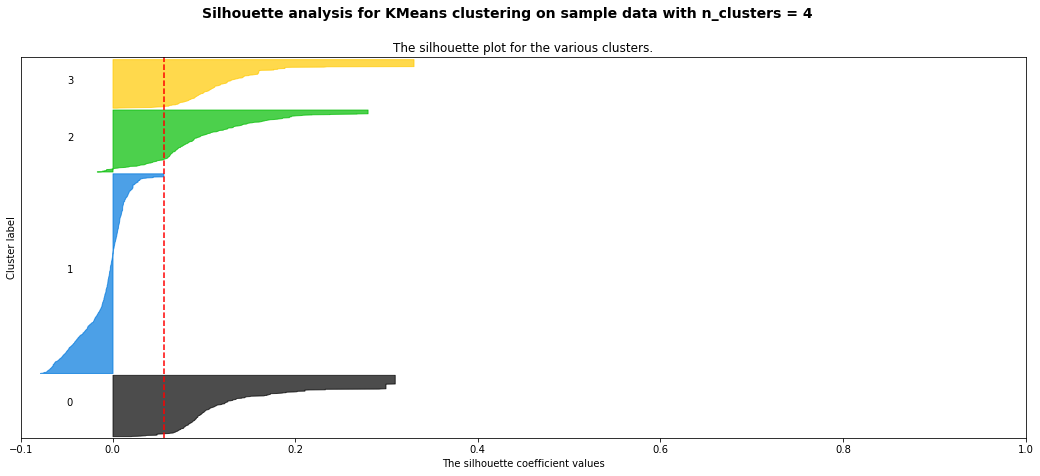

For n_clusters = 5 The average silhouette_score is : 0.0663671711959


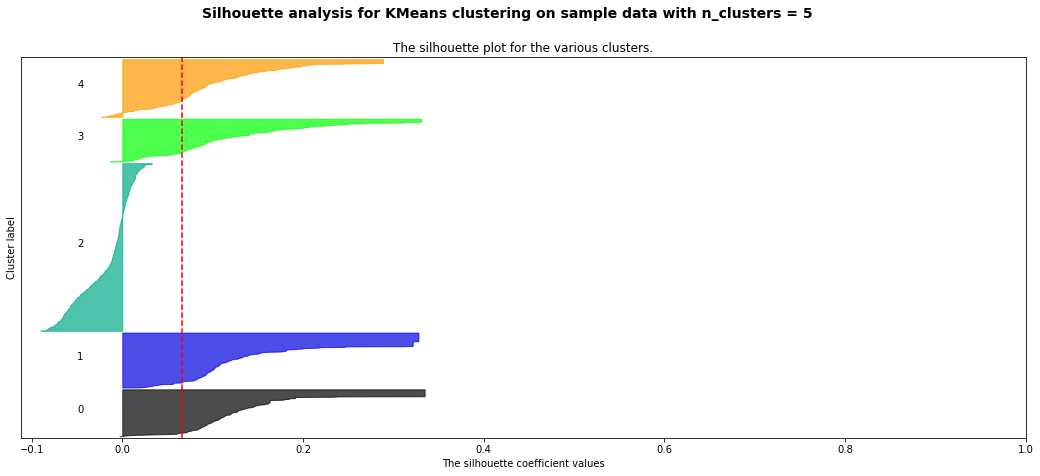

For n_clusters = 6 The average silhouette_score is : 0.0746881274282


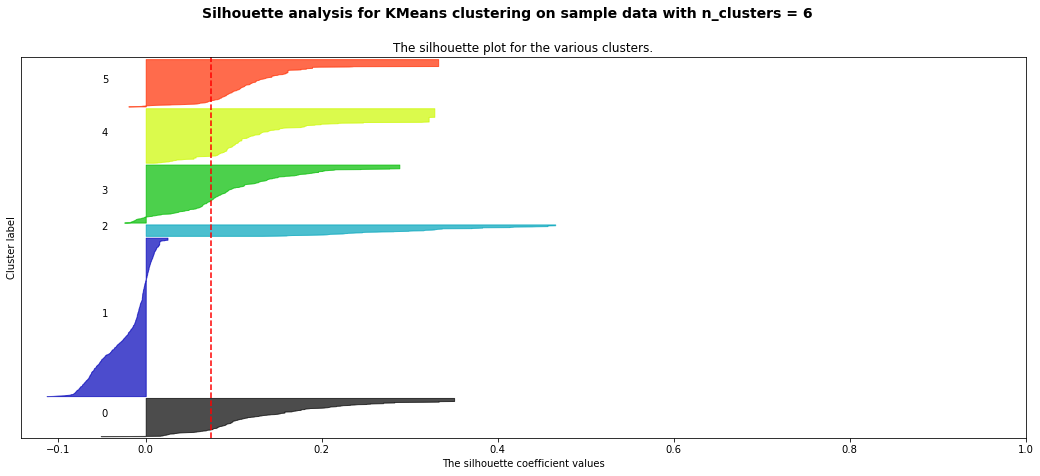

In [52]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

range_n_clusters = [2, 3, 4, 5, 6]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, ax1 = plt.subplots(1, 1)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
#     ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, X.shape[0] + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

    plt.show()